## Validation Set Approach
    -Drawbacks
        1.) The validation estiamte of the test error rate can be highly variable, depending
        on precisely which observations are included in the training set and which observations are
        included in the validation set
        
        2.) In the validation approach, only a subset of observations -- those that are included in 
        the training set rather than in the validation set -- are used to fit the model. Since statistical
        methods tend to perform worse when trained on fewer observations, this suggests tha the validaiton
        set error rate may tend to overestimate the test error rate for the model fit on the entire data set.

## Leave - One - Out Cross Validation (LOOCV)
    LOOCV involves splitting the set of observations into two part. However, intstead of creating two subsets
    of comparable size, a single observation, (x1, y1), is used for the validation set, and the remaining 
    observations make up the training set. The stat model is fit on n-1 training observations, and a prediciton of y is made for the excluded observation

In [109]:
from sklearn.datasets import california_housing , load_boston
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import ImportFunctions.MultipleLinearRegression as MLR
import matplotlib.pyplot as plt


calihousing = california_housing.fetch_california_housing()
data = pd.DataFrame(calihousing.data,columns=calihousing.feature_names)
data = data[['MedInc','AveBedrms','AveRooms','HouseAge','AveOccup']]
target = calihousing.target
X_train,X_test,y_train,y_test = train_test_split(data,target,test_size=0.25, random_state=42)

In [110]:
boston = load_boston()
dataB = pd.DataFrame(boston.data,columns=boston.feature_names)
dataB = dataB[['NOX','RM','AGE','DIS','CRIM']]
target= boston.target
X_train,X_test,y_train,y_test = train_test_split(dataB,target,test_size=0.25, random_state=42)

In [111]:
loss= y_train - X_train.dot(np.array([0,0,0,0,0]))

X_train.T.dot(loss)/ len(y_train)

NOX       12.327762
RM       149.669820
AGE     1493.586781
DIS       91.086426
CRIM      49.733721
dtype: float64

In [112]:
def LOO_CV(X,y):
    
    LOO_CV_results, coeffs_avg =[], []
    
    for i in range(len(X)):


        '''
        split training data into a leaveout and a trainset
        n_leaveout: number of records we want to remove for prediction
        '''

        errors = []
        
        X = X.reset_index()
        X.drop('index',axis=1,inplace=True)
        
        indices = X.index.tolist()
        validation_indices = indices[i]
        
        
        validation_X = X.iloc[validation_indices:validation_indices+1]
        validation_y = y[validation_indices]
        


        train_X = X.drop(validation_indices)
        train_y = np.delete(y, validation_indices)



        coeff  =MLR.LinearRegression(train_X,train_y,0.0001,1000,step_loss=False)
        
        prediction = MLR.predict(validation_X,coeff)
      
        
        
        
        LOO_CV_results.append(tuple([prediction,validation_y]))
        coeffs_avg.append(list(coeff.values))
    
    LOOCV_Df = pd.DataFrame(LOO_CV_results,columns=['Prediction','Hold_Out']), coeffs_avg
    LOOCV_Df['Prediction'] = [str(i).split()[1] for i in LOOCV_Df['Prediction']]
    return pd.DataFrame(LOO_CV_results,columns=['Prediction','Hold_Out']), coeffs_avg

In [117]:
LOO_CV_results, coefficients=LOO_CV(X_train,y_train)

In [58]:
LOO_CV_results.plot()


## K-Fold CV

This approach invovlves randomly dividing the set of observations into "$k$" groups (or folds) of
approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining $k$ -1 folds. For a regression approach, the MSE is computed on the hold-out set. This procedure is repeated k times; each time a different group of observations is treated as the validation set. This approach is advantages over LOOCV computationally. Rather than iternating $n$ times, k-fold is only computed $k$ times. 
    
K-fold often gives more accurate estaimtes than the LOOCV. This is due to the bia-variance trade off. While the LOOCV has preferrable bias compared to the k-fold approach, the trade-off is a balancing act. It turnsout that LOOCV has higher variance than does k-fold CV with k<n. Whyis this the case? When we perform LOOCV, we are in effect averaging the outputs of n fitted models, each of which is trained on an almost identical set of observations; therefore, these outputs are highly (positively) correlated with each other. In contrast, when we perform k-fold CV with k<n, we are averaging the outputs of k fitted models that are somewhat less correlated with each other, since the overlap between the training sets in each model is smaller. Since the mean of many highly correlated quantities has higher variance than does the mean of many quantities that are not highly correlated. 
</br>

In [114]:
def kfold_CV(X,y,n_folds):
    
    scores =[]

    for i in range(n_folds):
        X_ = X.reset_index()
        X_=X_.drop('index',axis=1)
        indices = X_.index.tolist()
        foldsize = int(len(X)/n_folds)
        ranSample = random.sample(indices, k=foldsize)
        validation_X = X_.loc[ranSample]
        validation_y = y[ranSample]

        train_X = X_.drop(ranSample)
        train_y = np.delete(y, ranSample)

        coeff  =MLR.LinearRegression(train_X,train_y,0.0001,10,step_loss=False)
        prediction = MLR.predict(validation_X,coeff)

        RMSE = np.sqrt(np.mean((prediction-validation_y)**2))
        scores.append(RMSE)
    return scores
    
    

Text(0.5, 1.0, 'k-fold')

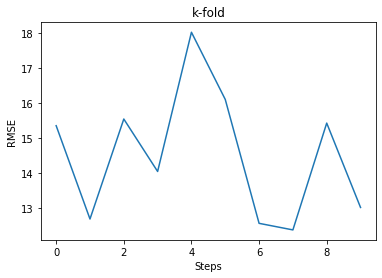

In [116]:
scores = kfold_CV(X_train,y_train,10)
    

plt.plot(scores)
plt.xlabel('Steps')
plt.ylabel('RMSE')
plt.title('k-fold')